#Source Code for *An End-to-end Methodology for Semi-Supervised HAR Data Collection, Labeling, and Classification Using a Wristband* presented at IE2022 WISHWell Workshop June 2022.

Authors:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/) and Gentry Atkinson, [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2022

We hope you find this code and the [TWristAR dataset](https://zenodo.org/record/5911808) useful and would appreciate your citation if used.
```
@dataset{lee_b_hinkle_2022_5911808,
  author       = {Lee B. Hinkle and
                  Gentry Atkinson and
                  Vangelis Metsis},
  title        = {TWristAR - wristband activity recognition},
  month        = jan,
  year         = 2022,
  publisher    = {Zenodo},
  version      = {1.0.0},
  doi          = {10.5281/zenodo.5911808},
  url          = {https://doi.org/10.5281/zenodo.5911808}
}
```

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

The original internal repository name was e4_end_to_end.ipynb, much of the logging code has been removed for better readability and compatibility.  This version also uses the publicly available copy of the TWristAR dataset.



# Imports

In [ ]:
import os
import shutil
import time
from time import gmtime, strftime, localtime #for displaying Linux UTC timestamps in hh:mm:ss
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Get TWristAR dataset from Zenodo

In [ ]:
my_dir = "." # replace with absolute path if desired (untested)
TWristAR_version = '1.0'
print("Downloading TWristAR Version",TWristAR_version,"into", my_dir)

if (TWristAR_version == '1.0'):
    !wget 'https://zenodo.org/record/5911808/files/TWristAR.zip'
else:
    print('ERROR: unknown version',TWristAR_version)

--2022-05-25 20:45:59--  https://zenodo.org/record/5911808/files/TWristAR.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2023608 (1.9M) [application/octet-stream]
Saving to: ‘TWristAR.zip’

TWristAR.zip        100%[===================>]   1.93M  2.13MB/s    in 0.9s    

2022-05-25 20:46:01 (2.13 MB/s) - ‘TWristAR.zip’ saved [2023608/2023608]



# Unzip the dataset

In [ ]:
def unzip_e4_file(zip_ffname, working_dir):
    """checks for local copy, if none unzips the e4 zipfile in working_dir
    Note:  the files themselves do not contain subject info and there are
    multiple files e.g. ACC.csv, BVP,csv etc, in each zipfile.
    It is very important to further process the files with <fname>_labels.csv
    :param zip_ffname: the path and filename of the zip file
    :param working_dir: local (colab) directory where csv files will be placed
    :return: nothing"""
    if (os.path.isdir(os.path.join(working_dir, 'TWristAR'))):
        print("Skipping Unzip - Found existing archive at", working_dir)
        return
    else:
        # print("Using source file", zip_ffname)
        print("Unzipping e4 file in directory ", working_dir)
        if (os.path.exists(zip_ffname)):
            shutil.unpack_archive(zip_ffname,working_dir,'zip')
        else:
            print("Error: ", zip_ffname, " not found, exiting")
            return
unzip_e4_file('TWristAR.zip',my_dir)

Unzipping e4 file in directory  .


# Download alternate labels from github repo
Quick explanation is in the README in the alt-labels directory.
Short version: sub 11 and 21 are just a few of the trials performed by sub 1 and
2 - this way those specific trials can be put into the validation set without modifying the existing code.

Downloading these even though the repo has probably been cloned
locally for portability (e.g. to run in colab).

In [ ]:
alt_labels_list = ['sub1/1574621345_A01F11_labels.csv',
                   'sub1/1574622389_A01F11_labels.csv',
                   'sub1/1574624998_A01F11_labels.csv',
                   'sub2/1633107019_A01F11_labels.csv',
                   'sub2/1633108344_A01F11_labels.csv',
                   'sub2/1633109744_A01F11_labels.csv']
for fname in alt_labels_list:
    os.remove(os.path.join(my_dir, "TWristAR", fname))
    alt_fname = 'https://raw.githubusercontent.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/main/alt-labels/' + fname
    dest_dir = os.path.join(my_dir, "TWristAR", fname.split('/')[0])
    print ('Copying', alt_fname, 'into', dest_dir)
    !wget $alt_fname -P $dest_dir
    #print (os.path.join(my_dir, "TWristAR", fname.split('/')[0]))

Copying https://raw.githubusercontent.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/main/alt-labels/sub1/1574621345_A01F11_labels.csv into ./TWristAR/sub1
--2022-05-25 20:46:06--  https://raw.githubusercontent.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/main/alt-labels/sub1/1574621345_A01F11_labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 768 [text/plain]
Saving to: ‘./TWristAR/sub1/1574621345_A01F11_labels.csv’

1574621345_A01F11_l 100%[===================>]     768  --.-KB/s    in 0s      

2022-05-25 20:46:07 (31.2 MB/s) - ‘./TWristAR/sub1/1574621345_A01F11_labels.csv’ saved [768/768]

Copying https://raw.githubusercontent.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/main/alt-labels/sub1/1574622389_A01F11_labels.csv into ./TWristAR/sub1
-

#The functions in the next cell are used to turn the dataset into X, y, sub numpy ndarrays
This code is based on the TWristAR demo code.

In [ ]:
def df_from_e4_csv (ffname,col_labels):
    """"reads e4 csv file, uses start time and sample rate to create time indexed
    pandas dataframe.  Note only tested with ACC files, e4 csv files do not
    have header info, this will need to be added based on file type.
    :param ffname:  full filename e.g./content/temp/ACC.csv
    :col_labels: list of colums in csv - varies by type ['accel_x','accel_y...]
    :returns df: time indexed dataframe"""

    df = pd.read_csv(ffname, header=None)
    # start_time = pd.to_datetime(df.iloc[0,0]). #pain to convert too early
    # time.time() supports number of seconds which is what this is
    start_time = df.iloc[0,0] # first line in e4 csv
    sample_freq = df.iloc[1,0] # second line in e4 csv
    df = df.drop(df.index[[0,1]]) # drop 1st two rows, index is now off by 2
    print(ffname, "Sample frequency = ", sample_freq, " Hz")
    # show time in day month format, assumes same timezone
    print("File start time = ", strftime("%a, %d %b %Y %H:%M:%S", localtime(start_time)))  
    # Make the index datetime first so code can be used for other data types
    # Having the index as datetime is required for pandas resampling
    # The start_time pulled from the e4 csv file is a float64 which represents the
    # number of seconds since January 1, 1970, 00:00:00 (UTC)
    # UTC_time is computed for each row, then made into required datetime format
    # that pandas will accept as an index
    df['UTC_time'] = (df.index-2)/sample_freq + start_time
    end_time = df['UTC_time'].iloc[-1]
    print("File end time   = ",strftime("%a, %d %b %Y %H:%M:%S", localtime(end_time)))
    df['datetime'] = pd.to_datetime(df['UTC_time'], unit='s')
    df.set_index('datetime',inplace=True)
    df = df.drop('UTC_time', axis=1)
    df.columns = col_labels
    return df
def process_e4_accel(df):
    """converts component accel into g and adds accel_ttl column
    per info.txt range is [-2g, 2g] and unit in this file is 1/64g.
    """
    df['accel_x'] = df['accel_x']/64
    df['accel_y'] = df['accel_y']/64
    df['accel_z'] = df['accel_z']/64
    df_sqd = df.pow(2)[['accel_x', 'accel_y', 'accel_z']] # square each accel
    df_sum = df_sqd.sum(axis=1) # add sum of squares, new 1 col df
    df.loc[:,'accel_ttl'] = df_sum.pow(0.5)-1  # sqrt and remove 1g due to gravity
    del df_sqd, df_sum
    return df
def show_tag_time(tag_ffname):
    """utility prints time marks from tags.csv to help with video sync 
    and labeling.   When this is run in colab it seems to be GMT regardless
    of timezone settings."
    :param tag_ffname: file to be processed e.g. /content/temp/tags.csv'
    :return: nothing"""
    df_temp = pd.read_csv(tag_ffname, header=None)
    df_temp.columns = ['UTC_time']
    print ("    UTC_time          Local Time")
    for index, row in df_temp.iterrows():
        print(index, row['UTC_time'],
            strftime("%a, %d %b %Y %H:%M:%S", localtime(row['UTC_time'])))
# https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
# link to string formats for date and time
def label_df_from_csv (df, labels_ffname):
    """adds activity label and subject number to the dataframe based on the
    contents of a .csv file containing time and label info.
    Example csv format (see e4_time_sync.xlsx to help build csv from video)
        start,finish,label,sub
        2019:11:24 18:49:51,2019:11:24 18:50:18,Upstairs,1
        2019:11:24 18:50:18,2019:11:24 18:50:45,Downstairs,1
    :param df : time indexed dataframe from df_from_e4_csv method
    :labels_ffname : csv file with metadata
    :return : a dataframe with label and subject columns added"""
    df_labels = pd.read_csv(labels_ffname)
    df_labels['start'] =  pd.to_datetime(df_labels['start'], format='%Y:%m:%d %H:%M:%S')
    df_labels['finish'] =  pd.to_datetime(df_labels['finish'], format='%Y:%m:%d %H:%M:%S')
    # quick check to make sure all subjects are the same - only 1 sub per csv
    if (not (df_labels['sub'].eq(df_labels['sub'].iloc[0]).all())):
        print('Warning: Multiple subjects detected in csv, unusual for e4 data.')
    df['label']='Undefined' # add column with safe value for labels
    df['sub'] = np.NaN
    for index, row in df_labels.iterrows():
        df.loc[row['start']:row['finish'],'label'] = row['label']
        df.loc[row['start']:row['finish'],'sub'] = row['sub']
    return df
    
def split_df_to_timeslice_nparrays(df, time_steps, step):
    """slice the df into segments of time_steps length and return X, y, sub
    ndarrays.  This is specific to an e4 ACC.csv file processed into dataframe.
    """
    N_FEATURES = 4 # maybe better to use # columns minus 2 (label and sub)
    # TODO - better yet pass in feature names and use length to set
    # if step = time_steps there is no overlap
    segments = []
    labels = []
    subject = []
    for i in range(0, len(df) - time_steps, step):
        df_segX = df[['accel_x', 'accel_y', 'accel_z','accel_ttl']].iloc[i: i + time_steps]
        df_lbl = df['label'].iloc[i: i + time_steps]
        df_sub = df['sub'].iloc[i: i + time_steps]
        # Save only if labels are the same for the entire segment and valid
        if (df_lbl.value_counts().iloc[0] != time_steps):
            # print('Segment at','contains multiple labels.  Discarding.')
            continue

        if 'Undefined' in df_lbl.values :
            # print('Segment contains Undefined labels.  Discarding')
            continue
        # Save only if sub is the same for the entire segment and valid
        if (df_sub.value_counts().iloc[0] != time_steps):
            print('Segment at','contains multiple subjects.  Discarding.')
            continue
        segments.append(df_segX.to_numpy())
        labels.append(df['label'].iloc[i])
        subject.append(df['sub'].iloc[i])

    # Bring the segments into a better shape, convert to nparrays
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    subject = np.asarray(subject)
    # both labels and sub are row arrays, change to single column arrays
    labels = labels[np.newaxis].T
    subject = subject[np.newaxis].T
    # check for nan - issue with resampled data
    bad_data_locations = np.argwhere(np.isnan(reshaped_segments))
    np.unique(bad_data_locations[:,0]) #[:,0] accesses just 1st column
    if (bad_data_locations.size!=0):
        print("Warning: Output arrays contain NaN entries")
        print("execute print(X[99]) # to view single sample")
    return reshaped_segments, labels, subject
def get_X_y_sub(
    working_dir = os.path.join(my_dir + '/TWristAR_temp'), # this directory will be created inside colab
    zip_dir = os.path.join(my_dir + '/TWristAR'), # where unzipped
    zip_flist = [],
    time_steps = 96,  # 32Hz sampling rate so each window is 3 seconds long
    step = 32 # if equal to time_steps there will be no overlap of sliding window
    ):
    """processes e4 zip file and associated label csv file into X (data),
     y (labels), and sub (subject number) ndarrays.
     Returns X, y, sub, xys_info (a text file)
    """
    # create blank ndarrays to append to
    my_X = np.zeros(shape=(1,time_steps,4))
    my_y = np.full(shape=(1,1), fill_value='n/a',dtype='<U10') # unicode 10 char
    my_sub = np.zeros(shape=(1,1),dtype=int) # one subject number per entry
    for i in zip_flist:
        zip_ffname = zip_dir + '/' + i
        print('Processing ', i)
        unzip_e4_file(zip_ffname, working_dir)
        # following portion of code is unique to ACC only files
        ffname = working_dir + '/ACC.csv'
        col_labels = ['accel_x', 'accel_y', 'accel_z']
        my_df = df_from_e4_csv(ffname, col_labels)
        my_df = process_e4_accel(my_df)
        #print(my_df.head())
        print('Tag info (button presses) from tags.csv')
        tag_ffname = working_dir + '/tags.csv'
        show_tag_time(tag_ffname)
        # Generate associated csv filename, forces the long numbered filenames to match
        labels_ffname = os.path.splitext(zip_ffname)[0] + '_labels.csv'
        #print ('label file ', labels_ffname)
        my_df = label_df_from_csv (my_df, labels_ffname)
        my_df['label'].value_counts()
        print ("Label Counts - # samples before sliding window\n",my_df['label'].value_counts())
        temp_X, temp_y, temp_sub = split_df_to_timeslice_nparrays(my_df, time_steps, step)
        #print(get_shapes([temp_X, temp_y, temp_sub]))
        #print(temp_X[:5]) # "head" for ndarray
        #print(temp_y[:5])
        #print(temp_sub[:5])
        my_X = np.vstack([my_X, temp_X])
        my_y = np.vstack([my_y, temp_y])
        my_sub = np.vstack([my_sub, temp_sub])
        shutil.rmtree(working_dir)

    # delete first row placeholders
    X = np.delete(my_X, (0), axis=0) 
    y = np.delete(my_y, (0), axis=0) 
    sub = np.delete(my_sub, (0), axis=0)
    sub = sub.astype(int) # convert from float to int

    # Print final counts for label ndarray - not quite as easy as pandas df
    print("Final Label Counts")
    unique, counts = np.unique(y, return_counts=True)
    print (np.asarray((unique, counts)).T)
    print("Samples per Subject")
    unique, counts = np.unique(sub, return_counts=True)
    print (np.asarray((unique, counts)).T)

    xys_info = 'e4 structured 6-activity zip files\n'
    xys_info += '\n'.join([str(elem) for elem in zip_flist]) # conv list to string
    xys_info += '\nTime steps =' + str(time_steps) + ', Step =' + str(step) + ', no resample\n'
    xys_info += 'Final Shapes\n'
    xys_info += "X shape " + str(X.shape) + " dtype = " + str(X.dtype) + "\n"
    xys_info += "y shape " + str(y.shape) + " dtype = " + str(y.dtype) + "\n"
    xys_info += "sub shape " + str(sub.shape) + " dtype = " + str(sub.dtype) + "\n"
    return X, y, sub, xys_info

# Get the numpy arrays using e4_load_dataset.py
This code is from the original e4, the TWristAR demo code was modified to store the numpy arrays to speed up the hold-one-subject out execution.

In [ ]:
def e4_load_dataset(
    verbose = True,
    incl_xyz_accel = False, # include component accel_x/y/z in ____X data
    incl_rms_accel = True, # add rms value (total accel) of accel_x/y/z in ____X data
    incl_val_group = False, # split train into train and validate
    split_subj = dict
                (train_subj = [1,2],
                validation_subj = [11,21], #this is middle activity sub1&2
                test_subj = [3]),
    one_hot_encode = True # make y into multi-column one-hot, one for each activity
    ):
    """calls e4_get_X_y_sub and processes the returned arrays by separating
    into _train, _validate, and _test arrays for X and y based on split_sub
    dictionary."""
    e4_flist = ['sub1/1574621345_A01F11.zip',
                'sub1/1574622389_A01F11.zip',
                'sub1/1574624998_A01F11.zip',
                'sub2/1633107019_A01F11.zip',
                'sub2/1633108344_A01F11.zip',
                'sub2/1633109744_A01F11.zip',
                'sub3/1633704587_A01F11.zip',
                'sub3/1633705664_A01F11.zip',
                'sub3/1633711821_A01F11.zip']
    #e4_flist = ['1574621345_A01F11.zip','1574622389_A01F11.zip', '1574624998_A01F11.zip']
    X, y, sub, xys_info = get_X_y_sub(zip_flist = e4_flist)
    log_info = 'Processing e4 files'+str(e4_flist)
    #remove component accel if needed
    if (not incl_xyz_accel):
        print("Removing component accel")
        X = np.delete(X, [0,1,2], 2)
    if (not incl_rms_accel):
        print("Removing total accel")
        X = np.delete(X, [3], 2)  
    #One-Hot-Encode y...there must be a better way when starting with strings
    #https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

    if (one_hot_encode):
        # integer encode
        y_vector = np.ravel(y) #encoder won't take column vector
        le = LabelEncoder()
        integer_encoded = le.fit_transform(y_vector) #convert from string to int
        name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print("One-hot-encoding: category names -> int -> one-hot")
        print(name_mapping) # seems risky as interim step before one-hot
        log_info += "One Hot:" + str(name_mapping) +"\n\n"
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        print("One-hot-encoding",onehot_encoder.categories_)
        y=onehot_encoded
        #return X,y
    # split by subject number pass in dictionary
    sub_num = np.ravel(sub[ : , 0] ) # convert shape to (1047,)
    if (not incl_val_group):
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj'] + 
                                        split_subj['validation_subj']))
        x_train = X[train_index]
        y_train = y[train_index]
    else:
        train_index = np.nonzero(np.isin(sub_num, split_subj['train_subj']))
        x_train = X[train_index]
        y_train = y[train_index]

        validation_index = np.nonzero(np.isin(sub_num, split_subj['validation_subj']))
        x_validation = X[validation_index]
        y_validation = y[validation_index]

    test_index = np.nonzero(np.isin(sub_num, split_subj['test_subj']))
    x_test = X[test_index]
    y_test = y[test_index]
    if (incl_val_group):
        return x_train, y_train, x_validation, y_validation, x_test, y_test
    else:
        return x_train, y_train, x_test, y_test


        if(verbose):
            headers = ("Reshaped data","shape", "object type", "data type")
            mydata = [("x_train:", x_train.shape, type(x_train), x_train.dtype),
                    ("y_train:", y_train.shape ,type(y_train), y_train.dtype),
                    ("x_test:", x_test.shape, type(x_test), x_test.dtype),
                    ("y_test:", y_test.shape ,type(y_test), y_test.dtype)]
            print(tabulate(mydata, headers=headers))

        return x_train, y_train, x_test, y_test

# Run load_dataset to get the training, validation, and test numpy arrays

In [ ]:
DATASET = "e4_Nov2019" 

x_train, y_train, x_validate, y_validate, x_test, y_test = e4_load_dataset(incl_val_group = True, incl_xyz_accel= True)
#x_train, y_train, x_test, y_test = e4_load_dataset(incl_val_group = False, incl_xyz_accel= True)
t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
dataset_info = "Data imported from " + DATASET + "\n"
dataset_info += "This pass for paper images, train validate are sub1 and sub2 with\n"
dataset_info += "62%/28% split - course because it is by activity.  Test = sub3\n"

print(dataset_info)

Processing  sub1/1574621345_A01F11.zip
Unzipping e4 file in directory  ./TWristAR_temp
./TWristAR_temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574621375.17 Sun, 24 Nov 2019 18:49:35
1 1574621774.22 Sun, 24 Nov 2019 18:56:14
Label Counts - # samples before sliding window
 Upstairs      6208
Downstairs    5889
Undefined     5405
Name: label, dtype: int64
Processing  sub1/1574622389_A01F11.zip
Unzipping e4 file in directory  ./TWristAR_temp
./TWristAR_temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 19:06:29
File end time   =  Sun, 24 Nov 2019 19:15:03
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574622432.21 Sun, 24 Nov 2019 19:07:12
1 1574622822.72 Sun, 24 Nov 2019 19:13:42
Label Counts - # samples before sliding window
 Walking      5793
Jogging      5792
Undefined  

# Functions to Build, Train, and Run a Keras 1D-CNN 
topology and good article [here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [ ]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

def build_1D_CNN(num_filters = 100, k1_size=17, k2_size=17, dropout = 0.5, mpool_size = 2):
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
        layers.Input(shape=x_train[0].shape),
        layers.BatchNormalization(scale=False),
        layers.Conv1D(filters=num_filters, kernel_size=k1_size, activation='relu',input_shape=(n_timesteps,n_features)),
        layers.Dropout(dropout),
        layers.Conv1D(filters=num_filters, kernel_size=k2_size, activation='relu'),
        layers.Dropout(dropout),
        layers.MaxPooling1D(pool_size=mpool_size),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ])
  return model 

def train_1D_CNN(model,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    MAX_EPOCHS = 200): # Max number run unless earlystopping callback fires
    # increasing dropout to 0.8 and higher requires more than 100 epochs
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=20)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=MAX_EPOCHS,
        callbacks=[callback],
        validation_data=(x_validate,y_validate),
        verbose = 0) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history

def run_model(model, testX, testy, returnOneHot=False):
    predictions = model.predict(testX, verbose=0,batch_size=32)
    # must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_temp = np.argmax(testy, axis=-1)
    if returnOneHot:
        return (accuracy_score(y_temp, y_pred)),y_pred, predictions
    else:
        return (accuracy_score(y_temp, y_pred)),y_pred

# Train, Evaluate using Validation Set, and Save Final Model - 10 passes

In [ ]:
save_log = False # True = write results to disk
repeats = 10
best_acc = 0
for repeat_num in range(repeats):
    model = build_1D_CNN(k1_size=11, k2_size=5,
                         dropout = 0.5,
                         mpool_size = 8)
    if (repeat_num == 0):
        model.summary()
    history = train_1D_CNN(model)
    val_acc = history.history['val_accuracy'][-1]
    print("Training pass", repeat_num+1, "of", repeats, 
          "Validation Accuracy", '{0:.3f}'.format(val_acc))
    if (val_acc > best_acc):
        best_model = model
    latex_fmt = False
    if (latex_fmt):
        col_sep = '&' # for import as LaTeX table
        end_line = '\\\\ \\hline\n' # end of table row with underline for latex
    else: #csv
        col_sep = ',' # for csv
        end_line = '\n' # for csv
    if (repeat_num == 0):
        header = 'Accuracy'+ col_sep + str(repeat_num + 1)
        val_acc_str = 'Validation'+ col_sep + '{0:.3f}'.format(val_acc)
        cumm_val_acc = val_acc
    else:
        header += col_sep + str(repeat_num + 1)
        val_acc_str += col_sep + '{0:.3f}'.format(val_acc)
        cumm_val_acc += val_acc
header += col_sep + 'Avg' + end_line
val_acc_str += col_sep + '{0:.3f}'.format(cumm_val_acc/repeats)+ end_line
#print (header, val_acc_str) # for clipping into tables
best_model.save('my_1D_CNN_model')
if save_log:
    log_ffname = os.path.join(my_dir, "SemiSup_Results.txt")
    print("Saving results to", log_ffname)
    with open(log_ffname, "a") as file_object:
            file_object.write(dataset_info)
            file_object.write("Model training\n")
            file_object.write(header)
            file_object.write(val_acc_str)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 96, 4)            12        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 86, 100)           4500      
                                                                 
 dropout (Dropout)           (None, 86, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 100)           50100     
                                                                 
 dropout_1 (Dropout)         (None, 82, 100)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 100)          0         
 )                                                      

# Run Saved Model on Scripted Test Set

              precision    recall  f1-score   support

  Downstairs       0.74      0.80      0.77       173
     Jogging       0.90      0.61      0.72       173
     Sitting       0.94      0.93      0.93       171
    Standing       0.92      0.70      0.80       186
    Upstairs       0.83      0.89      0.86       198
     Walking       0.66      0.92      0.77       190

    accuracy                           0.81      1091
   macro avg       0.83      0.81      0.81      1091
weighted avg       0.83      0.81      0.81      1091



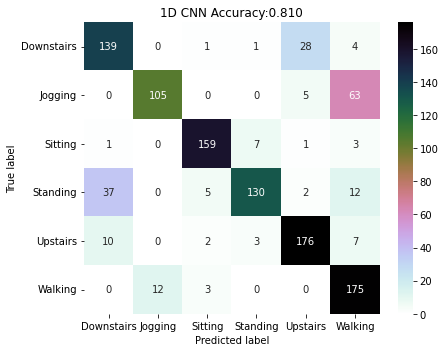

In [ ]:
model = keras.models.load_model('my_1D_CNN_model')
test_acc, y_pred = run_model(model, x_test, y_test)
#must use values not one-hot encoding, use argmax to convert
y_test_act = np.argmax(y_test, axis=-1) #undo one-hot encoding
class_rpt_for_log = classification_report(y_test_act, y_pred, target_names=t_names)
print(class_rpt_for_log)
cm = confusion_matrix(y_test_act, y_pred)
cm_df = pd.DataFrame(cm,
                    index = t_names, 
                    columns = t_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('1D CNN Accuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()
#save the confusion matrix figure as pdf
if save_log:
    with open(log_ffname, "a") as file_object:
        file_object.write("Classification Report on Test Set\n")
        file_object.write(class_rpt_for_log)
    cm_ffname = log_ffname.split('.')[0] + '_cm.pdf'
    print("saving cm plot as",cm_ffname)
    fig.savefig(cm_ffname,format='pdf')

In [ ]:
#save the model summary and model plot
if save_log:
    model = keras.models.load_model('my_1D_CNN_model')
    my_model = model.summary()
    full_model_fname = log_ffname.split('.')[0] + '_model.txt'
    with open(full_model_fname, "a") as file_object:
        model.summary(print_fn=lambda x: file_object.write(x + '\n'))
        #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
    #plot using keras function
    #ref https://keras.io/api/utils/model_plotting_utils/
    full_mplot_fname = log_ffname.split('.')[0] + '_model.png'
    tf.keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)

# Load the freeform walk file using e4_get_x_y_sub

In [ ]:
#These saved arrays from mode version of get_xys.  Mixed labeled windows are not dropped.
!wget https://github.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/raw/main/processed_ndarrays/sub1_unscripted/X.npy
!wget https://github.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/raw/main/processed_ndarrays/sub1_unscripted/y.npy
x_unscript = np.load('X.npy')
y_unscript = np.load('y.npy')

--2022-05-25 20:52:05--  https://github.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/raw/main/processed_ndarrays/sub1_unscripted/X.npy
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/main/processed_ndarrays/sub1_unscripted/X.npy [following]
--2022-05-25 20:52:05--  https://raw.githubusercontent.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/main/processed_ndarrays/sub1_unscripted/X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2021504 (1.9M) [application/octet-stream]
Saving to: ‘X.npy’

X.npy               100%[===================>]   1.93M  --

# Shape and plot the labels to match the prediction format (numbers 0-5)

In [ ]:
# Converting label strings to numbers based on one-hot dictionary
str_to_key_dict = {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
key_to_str_dict = dict([(value, key) for key, value in str_to_key_dict.items()])
print(key_to_str_dict)
y_unscript_labelnums = np.vectorize(str_to_key_dict.get)(y_unscript)
y_unscript_labelnums = np.ravel(y_unscript_labelnums[:,0]) #shape from [99,1] to [99,]

{0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking'}


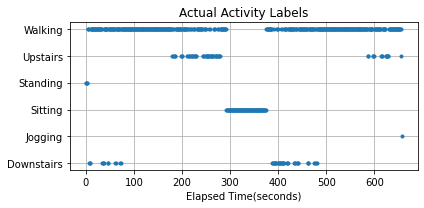

In [ ]:
# Plot the labeled data
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(y_unscript_labelnums,linestyle="",marker=".")
plt.title('Actual Activity Labels')
ax.set_xlabel('Elapsed Time(seconds)')
ax.set_yticks(np.arange(6))
ax.set_yticklabels(['Downstairs', 'Jogging','Sitting', 'Standing', 'Upstairs', 'Walking'])
ax.grid()
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

# Load saved final model and generate predictions

In [ ]:
model = keras.models.load_model('/content/my_1D_CNN_model')
predictions = model.predict(x_unscript, verbose=0,batch_size=32)
#must use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis

In [ ]:
# the one-hot encoding of the y_all here is meaningless since all labels are 'Not_Labeled'
# using output from train encoding, flip dictionary, use to build string version
# One-hot-encoding: category names -> int -> one-hot
str_to_key_dict = {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}
key_to_str_dict = dict([(value, key) for key, value in str_to_key_dict.items()])
print(key_to_str_dict)
y_pred_labels = np.vectorize(key_to_str_dict.get)(y_pred)
unique, counts = np.unique(y_pred_labels, return_counts=True)
print("Final Label Counts")
print (np.asarray((unique, counts)).T)

{0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking'}
Final Label Counts
[['Downstairs' '68']
 ['Sitting' '86']
 ['Standing' '1']
 ['Upstairs' '127']
 ['Walking' '376']]


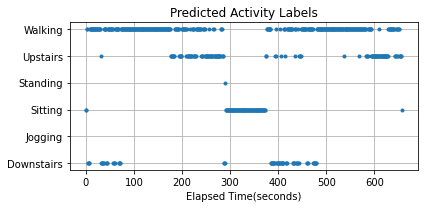

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(y_pred,linestyle="",marker=".")
plt.title('Predicted Activity Labels')
ax.set_xlabel('Elapsed Time(seconds)')
ax.set_yticks(np.arange(6))
ax.set_yticklabels(['Downstairs', 'Jogging','Sitting', 'Standing', 'Upstairs', 'Walking'])
ax.grid()
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

In [ ]:
#save the predicted activity plot as pdf
if save_log:
    fig_ffname = log_ffname.split('.')[0] + '_pred.pdf'
    print("saving prediction plot as",fig_ffname)
    fig.savefig(fig_ffname,format='pdf')

# Make a better plot to visualize the differences

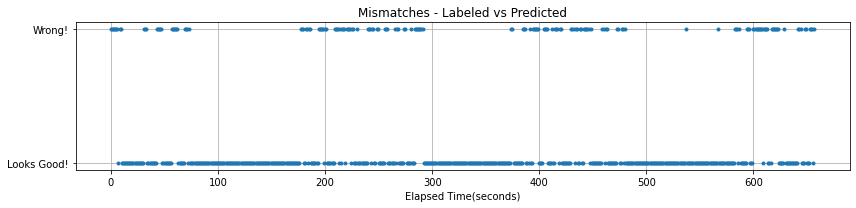

In [ ]:
delta_pred = np.subtract(y_unscript_labelnums, y_pred)
mis_pred = np.abs(delta_pred)
mis_pred_bool = np.where(mis_pred > 0.5, 1, 0)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(mis_pred_bool, linestyle="",marker=".")
plt.title('Mismatches - Labeled vs Predicted')
ax.set_xlabel('Elapsed Time(seconds)')
ax.set_yticks(np.arange(2))
ax.set_yticklabels(['Looks Good!', 'Wrong!'])
ax.grid()
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

In [ ]:
def label_confidence(l):
  return max(l)/sum(l)
CON_THRESHOLD = 0.6

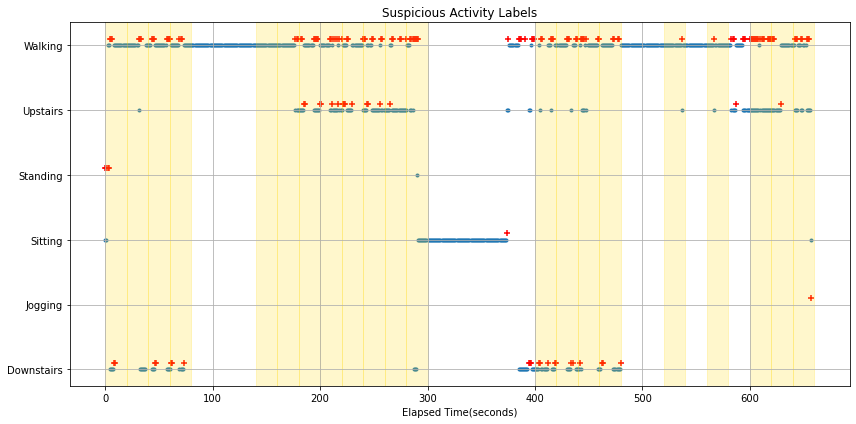

In [ ]:
gentry_mislabels = list()
for i in range(len(y_unscript_labelnums)):
    if y_pred[i] != y_unscript_labelnums[i]:
        gentry_mislabels.append((i, y_unscript_labelnums[i]))
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.scatter(range(len(y_pred)),y_pred,marker=".")
plt.title('Suspicious Activity Labels')
ax.set_xlabel('Elapsed Time(seconds)')
ax.set_yticks(np.arange(6))
ax.set_yticklabels(['Downstairs', 'Jogging','Sitting', 'Standing', 'Upstairs', 'Walking'])
ax.grid()

ax.scatter([i[0] for i in gentry_mislabels], [i[1]+0.1 for i in gentry_mislabels], marker='+', color='red')
for i in range(0, len(predictions), 20):
    if sum([label_confidence(j)<CON_THRESHOLD for j in predictions[i:i+20]]) >0:
     plt.axvspan(i, i+20, color='gold', alpha=0.2)
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()

if save_log:
    fig_ffname = log_ffname.split('.')[0] + '_suspicious.pdf'
    print("saving prediction plot as",fig_ffname)
    fig.savefig(fig_ffname,format='pdf')

In [ ]:
#Just a copy of what we ran to generate a by second ground truth and pred label file
print('i,y_gt,y_pred,')
for i in range(len(y_pred)):
    print (i,",", y_unscript_labelnums[i],"," ,y_pred[i])

i,y_gt,y_pred,
0 , 3 , 2
1 , 3 , 2
2 , 3 , 5
3 , 3 , 5
4 , 5 , 0
5 , 5 , 0
6 , 5 , 0
7 , 0 , 0
8 , 0 , 5
9 , 0 , 5
10 , 5 , 5
11 , 5 , 5
12 , 5 , 5
13 , 5 , 5
14 , 5 , 5
15 , 5 , 5
16 , 5 , 5
17 , 5 , 5
18 , 5 , 5
19 , 5 , 5
20 , 5 , 5
21 , 5 , 5
22 , 5 , 5
23 , 5 , 5
24 , 5 , 5
25 , 5 , 5
26 , 5 , 5
27 , 5 , 5
28 , 5 , 5
29 , 5 , 5
30 , 5 , 5
31 , 5 , 4
32 , 5 , 0
33 , 5 , 0
34 , 0 , 0
35 , 0 , 0
36 , 0 , 0
37 , 0 , 0
38 , 5 , 5
39 , 5 , 5
40 , 5 , 5
41 , 5 , 5
42 , 5 , 5
43 , 5 , 0
44 , 5 , 0
45 , 5 , 0
46 , 0 , 5
47 , 0 , 5
48 , 5 , 5
49 , 5 , 5
50 , 5 , 5
51 , 5 , 5
52 , 5 , 5
53 , 5 , 5
54 , 5 , 5
55 , 5 , 5
56 , 5 , 5
57 , 5 , 0
58 , 5 , 0
59 , 5 , 0
60 , 5 , 0
61 , 0 , 5
62 , 0 , 5
63 , 5 , 5
64 , 5 , 5
65 , 5 , 5
66 , 5 , 5
67 , 5 , 5
68 , 5 , 5
69 , 5 , 0
70 , 5 , 0
71 , 5 , 0
72 , 0 , 0
73 , 0 , 5
74 , 5 , 5
75 , 5 , 5
76 , 5 , 5
77 , 5 , 5
78 , 5 , 5
79 , 5 , 5
80 , 5 , 5
81 , 5 , 5
82 , 5 , 5
83 , 5 , 5
84 , 5 , 5
85 , 5 , 5
86 , 5 , 5
87 , 5 , 5
88 , 5 , 5
89 , 5 , 5
90 , 

# Build vtt file with predicted activity labels
Example format from the beginning of recorded and captioned video<pre>
WEBVTT

1
00:00:03.840 --> 00:00:13.920
Lee Hinkle: Alright Suzy a quick rundown of some work i've been doing on load data time series, and specifically for this particular session i'm going to talk about.

2
00:00:14.490 --> 00:00:23.550
Lee Hinkle: Work on doing with the E4 wristband and so first off, let me kind of ground, you know and the load data time to us and the idea behind this is.
</pre>

In [ ]:
START_SECS = 11 # this is the number of seconds of video before 1st label
STEP_SECS = 1 # this is the number of seconds until the next sample is evaluated
my_labels_vtt = 'WEBVTT\n\n' # header
my_labels_vtt += '1\n' # put in first line before labels
my_labels_vtt += '00:00:03.000 --> 00:00:10.000\n'
my_labels_vtt += 'activities shown are predictions by the trained model\n\n'

num_rows = np.shape(y_pred_labels)[0]
for i in range(2,num_rows):
    start = datetime.fromtimestamp(START_SECS + i*STEP_SECS)
    end = datetime.fromtimestamp(START_SECS+((i+1)*STEP_SECS))
    my_labels_vtt += str(i) + "\n"
    my_labels_vtt += start.strftime("%H:%M:%S.000")
    #my_labels_vtt += (time.strftime("%H:%M:%S.000", time.gmtime(START_TIME+i*STEP_SECS)))
    my_labels_vtt += " --> "
    my_labels_vtt += end.strftime("%H:%M:%S.000")
    #my_labels_vtt += (time.strftime("%H:%M:%S.000", time.gmtime(START_TIME+((i+1)*STEP_SECS))))
    my_labels_vtt += "\n"
    my_labels_vtt += y_pred_labels[i]
    if (label_confidence(predictions[i]) < CON_THRESHOLD):
       my_labels_vtt += "***\n\n"
       print(start.strftime("%H:%M:%S.000")+" Review")
    else:
        my_labels_vtt += "\n\n"
#print(my_labels_vtt) # pretty long and makes scrolling a pain, should make 'head' type call
#acknowledgement https://stackoverflow.com/users/2146491/b%c5%82a%c5%bcej-michalik
#this is a 'tail' type call
print('\n'.join(my_labels_vtt.splitlines()[-20:]))

00:00:15.000 Review
00:00:42.000 Review
00:00:48.000 Review
00:00:57.000 Review
00:01:12.000 Review
00:02:32.000 Review
00:03:08.000 Review
00:03:12.000 Review
00:03:26.000 Review
00:03:30.000 Review
00:03:42.000 Review
00:03:44.000 Review
00:03:46.000 Review
00:03:48.000 Review
00:03:49.000 Review
00:04:06.000 Review
00:04:11.000 Review
00:04:15.000 Review
00:04:35.000 Review
00:04:37.000 Review
00:04:49.000 Review
00:04:51.000 Review
00:04:55.000 Review
00:04:56.000 Review
00:04:57.000 Review
00:04:59.000 Review
00:05:00.000 Review
00:07:06.000 Review
00:07:09.000 Review
00:07:10.000 Review
00:07:25.000 Review
00:07:28.000 Review
00:07:33.000 Review
00:07:34.000 Review
00:07:35.000 Review
00:07:41.000 Review
00:08:10.000 Review
00:09:07.000 Review
00:09:08.000 Review
00:09:37.000 Review
00:09:38.000 Review
00:09:47.000 Review
00:10:19.000 Review
00:10:33.000 Review
00:10:53.000 Review
00:10:58.000 Review
00:11:00.000 Review
00:11:08.000 Review
653
00:11:04.000 --> 00:11:05.000
Upstai

# Write vtt file

In [ ]:
if save_log:
    full_vtt_fname = 'semi_supr_cc.vtt'
    text_file = open(full_vtt_fname, "w")
    n = text_file.write(my_labels_vtt)
    text_file.close()

In [ ]:
for i in range(0, len(predictions), 20):
    start = datetime.fromtimestamp(0 + i*1)
    clean = True
    for l in predictions[i:i+20]:
        if label_confidence(l) < CON_THRESHOLD:
            clean = False
    print('{}\t\t{}'.format(start.strftime("%H:%M:%S.000"), 'Good' if clean else 'Review'))

00:00:00.000		Review
00:00:20.000		Review
00:00:40.000		Review
00:01:00.000		Review
00:01:20.000		Good
00:01:40.000		Good
00:02:00.000		Good
00:02:20.000		Review
00:02:40.000		Review
00:03:00.000		Review
00:03:20.000		Review
00:03:40.000		Review
00:04:00.000		Review
00:04:20.000		Review
00:04:40.000		Review
00:05:00.000		Good
00:05:20.000		Good
00:05:40.000		Good
00:06:00.000		Good
00:06:20.000		Good
00:06:40.000		Review
00:07:00.000		Review
00:07:20.000		Review
00:07:40.000		Review
00:08:00.000		Good
00:08:20.000		Good
00:08:40.000		Review
00:09:00.000		Good
00:09:20.000		Review
00:09:40.000		Good
00:10:00.000		Review
00:10:20.000		Review
00:10:40.000		Review
